# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [833]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

user_item_interaction = pd.read_csv('data/user-item-interactions.csv', dtype={"article_id":str})
content = pd.read_csv('data/articles_community.csv', dtype={"article_id": str})
content["article_id"] = content["article_id"].apply(lambda id: id + ".0")
del user_item_interaction['Unnamed: 0']
del content['Unnamed: 0']

# Show df to get an idea of the data
user_item_interaction.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [834]:
# Show df_content to get an idea of the data
content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [843]:
articles_in_user_item_inter & articles_in_content

{'0.0',
 '100.0',
 '1000.0',
 '1004.0',
 '1006.0',
 '1008.0',
 '101.0',
 '1014.0',
 '1015.0',
 '1016.0',
 '1017.0',
 '1018.0',
 '102.0',
 '1024.0',
 '1025.0',
 '1028.0',
 '103.0',
 '1030.0',
 '1035.0',
 '1038.0',
 '1042.0',
 '1043.0',
 '1044.0',
 '1047.0',
 '1048.0',
 '1050.0',
 '107.0',
 '108.0',
 '109.0',
 '110.0',
 '111.0',
 '112.0',
 '113.0',
 '115.0',
 '116.0',
 '117.0',
 '12.0',
 '120.0',
 '122.0',
 '124.0',
 '125.0',
 '130.0',
 '131.0',
 '132.0',
 '134.0',
 '136.0',
 '138.0',
 '14.0',
 '142.0',
 '143.0',
 '145.0',
 '146.0',
 '15.0',
 '151.0',
 '152.0',
 '153.0',
 '157.0',
 '158.0',
 '16.0',
 '162.0',
 '164.0',
 '173.0',
 '176.0',
 '18.0',
 '181.0',
 '183.0',
 '184.0',
 '188.0',
 '189.0',
 '191.0',
 '193.0',
 '194.0',
 '195.0',
 '2.0',
 '20.0',
 '202.0',
 '205.0',
 '210.0',
 '213.0',
 '215.0',
 '221.0',
 '223.0',
 '224.0',
 '225.0',
 '230.0',
 '232.0',
 '233.0',
 '234.0',
 '236.0',
 '237.0',
 '239.0',
 '240.0',
 '241.0',
 '244.0',
 '25.0',
 '250.0',
 '251.0',
 '252.0',
 '253.0',


In [844]:
len(articles_user_item_inter & articles_in_content)

437

In [849]:
articles_in_user_item_inter = set(user_item_interaction["article_id"].unique())
articles_in_content = set(content.article_id.unique())
print("There are a total of {} articles, {} in user_item_interaction df and {} in the content df".format(len(articles_in_user_item_inter | articles_in_content), len(articles_in_user_item_inter), len(articles_in_content)))
print("{} articles that are not in both dataframes".format(len(articles_in_content ^ articles_in_user_item_inter)))
print("{} articles con the user-item interaction dataframe that are not in the content df".format(len(articles_in_user_item_inter - articles_in_content)))
print("and {} unique users".format(user_item_interaction["email"].unique().shape[0]))

There are a total of 1328 articles, 714 in user_item_interaction df and 1051 in the content df
891 articles that are not in both dataframes
277 articles con the user-item interaction dataframe that are not in the content df
and 5149 unique users


In [850]:
n_interactions_by_user = user_item_interaction.groupby("email", as_index=False).agg({
    "article_id":[
        ("num_interactions",len), 
        ("unique_n_articles",lambda a: len(set(a)))
    ]})
n_interactions_by_user.columns = n_interactions_by_user.columns.get_level_values(1)
n_interactions_by_user.rename(columns={"":"email"}, inplace=True)
n_interactions_by_user.head()

,email,num_interactions,unique_n_articles
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13,12
1,001055fc0bb67f71e8fa17002342b256a30254cd,4,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6,5
4,001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [851]:
n_interactions_by_user["num_interactions"].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: num_interactions, dtype: float64

In [852]:
n_interactions_by_user["unique_n_articles"].describe()

count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: unique_n_articles, dtype: float64

<AxesSubplot:>

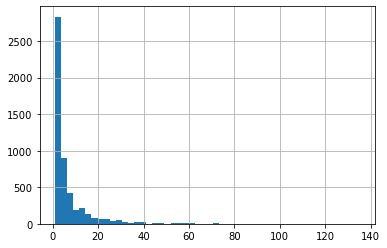

In [853]:
n_interactions_by_user["unique_n_articles"].hist(bins=50)

In [854]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [855]:
# Find and explore duplicate articles
content[content.duplicated(subset=["article_id"])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50.0
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221.0
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0


In [856]:
# Remove any rows that have the same article_id - only keep the first
content.drop_duplicates(subset=["article_id"], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [857]:
unique_articles = user_item_interaction["article_id"].nunique()
total_articles = content.shape[0]
unique_users = user_item_interaction["email"].nunique()
user_article_interactions = user_item_interaction.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [858]:
most_viewed_article_id =  str(views_by_article[views_by_article["total_views"]==max(views_by_article["total_views"])].index[0])
max_views = views_by_article["total_views"].max()

In [859]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
email_encoded = {email: i+1 for i, email in enumerate(user_item_interaction["email"].unique())}
user_item_interaction['user_id'] = user_item_interaction["email"].map(email_encoded)
del user_item_interaction['email']

# show header
user_item_interaction.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [860]:
views_by_article = user_item_interaction.groupby(["article_id"]).agg({
    "user_id": [("total_views",len), ("users", lambda u: u.nunique())],
    "title": [("title",max)]
})
views_by_article.columns = views_by_article.columns.get_level_values(1)
views_by_article.head()

,total_views,users,title
article_id,,,
0.0,14,12,detect malfunctioning iot sensors with streami...
100.0,9,9,use data assets in a project using ibm data ca...
1000.0,16,11,recommender systems: approaches & algorithms
1004.0,7,7,how to get a job in deep learning
1006.0,14,14,essentials of machine learning algorithms (wit...


In [861]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [862]:
def get_top_article_ids(n, views_by_article=views_by_article):
    '''
    INPUT:
    n - (int) the number of top articles to return
    views_by_article - (pandas dataframe) views by article df as defined in the previews section
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
 
    return views_by_article.sort_values("total_views", ascending=False).index[:n].tolist()

def get_top_articles(n, views_by_article=views_by_article):
    '''
    INPUT:
    n - (int) the number of top articles to return
    views_by_article - (pandas dataframe) views by article df as defined in the previews section
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_n_ids = get_top_article_ids(n, views_by_article)
    return views_by_article.loc[get_top_article_ids(n)]["title"].tolist()


In [864]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [865]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    return df.groupby(["user_id", "article_id"]).agg({"title": lambda t: 1})["title"].unstack().fillna(0)

user_item = create_user_item_matrix(user_item_interaction)

In [866]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [867]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_by_user = np.dot( user_item.loc[user_id].values, user_item.values.transpose() )
    similarity_by_user = pd.Series(similarity_by_user, index=user_item.index)
    # remove the own user's id
    similarity_by_user = similarity_by_user[similarity_by_user.index != user_id]
    # sort by similarity and then by number of articles read
    similarity_by_user.sort_values(ascending=False, inplace=True)
    return similarity_by_user.index.tolist() # return a list of the users in order from most to least similar
        

In [868]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [869]:
def get_article_names(article_ids, views_by_article=views_by_article):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    views_by_article - (pandas dataframe) views_by_article as defined in the previous section
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    return views_by_article.loc[article_ids]["title"].values.tolist() # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    articles_ids = user_item.loc[user_id][user_item.loc[user_id]!=0].index.tolist()
    
    
    return articles_ids, get_article_names(articles_ids) # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # articles read by the user
    articles_read = get_user_articles(user_id)[0]
    # get similar user ids
    similar_users = find_similar_users(user_id)
    recs = []
    # for every similar user
    for sim_user in similar_users:
        # get articles read by similar user
        rec_article_ids, rec_article_names = get_user_articles(sim_user)
        # add all the articles that are not in th articles read list
        recs += [article_id for article_id in rec_article_ids if article_id not in articles_read]
        if len(recs) >= m:
            # break if m is reached 
            break
    recs = recs[:m] # slice to have the exact number of recs
    
    return recs # return your recommendations for this user_id    

In [870]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [871]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [872]:
# add user id to n_interactions_by_user_df
n_interactions_by_user.index = n_interactions_by_user["email"].map(email_encoded)

In [873]:
def get_top_sorted_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    NOTES:
        - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    similarity_by_user = np.dot( user_item.loc[user_id].values, user_item.values.transpose() )
    similarity_by_user = pd.Series(similarity_by_user, index=user_item.index)
    # remove the own user's id
    similarity_by_user = similarity_by_user[similarity_by_user.index != user_id]
    similarity_by_user.name = "similarity"
    # merge with n_interactions_by_user
    similarity_by_user = similarity_by_user.to_frame().join(n_interactions_by_user)
    # sort by similarity and then by number of articles read
    similarity_by_user.sort_values(["similarity", "num_interactions"], ascending=False, inplace=True)
    # format the frame
    similarity_by_user = similarity_by_user.reset_index()[["user_id", "similarity", "num_interactions"]]
    similarity_by_user.rename(columns={"user_id":"neighbor_id"}, inplace=True)
    return similarity_by_user # Return the dataframe specified in the doc_string

def get_sorted_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    sorted by the number of times that each article was read
    '''
    articles_ids = user_item.loc[user_id][user_item.loc[user_id]!=0]
    articles = pd.DataFrame(index=articles_ids.index, data={
        "total_views": [views_by_article.loc[a_id]["total_views"] for a_id in articles_ids.index]
    })
    articles.sort_values(["total_views"], ascending=False, inplace=True)    
    
    return articles.index.tolist(), get_article_names(articles.index.tolist()) # return the ids and names


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # articles read by the user
    articles_read = get_user_articles(user_id)[0]
    # get similar user ids
    similar_users = get_top_sorted_users(user_id)["neighbor_id"]
    recs_ids = []
    recs_names = []
    # for every similar user
    for sim_user in similar_users:
        # get articles read by similar user
        rec_article_ids, rec_article_names = get_sorted_user_articles(sim_user)
        # add all the articles that are not in the articles read list
        for i, article_id in enumerate(rec_article_ids):
            if article_id not in articles_read:
                recs_ids.append(article_id)
                recs_names.append(rec_article_names[i])
        if len(recs_ids) >= m:
            # break if m is reached 
            break    
    # cut recs lists to m members
    recs_ids = recs_ids[:m]
    recs_names = recs_names[:m]
    return recs_ids, recs_names

In [874]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [875]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]["neighbor_id"]
user131_10th_sim = get_top_sorted_users(131).iloc[9]["neighbor_id"]

In [876]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

We could use the get_top_articles functions since we do not have any data about these users.
A better way would be to have the articles categorized by topic or type of post and ask the user to rate wich of the topics seems more interesting.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [877]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)



In [878]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [609]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [610]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [612]:
# Perform SVD on the User-Item Matrix, Funk SVD is not needed because there are not missing values
# in the User-Item Matrix

u, s, vt = np.linalg.svd(user_item)

It is possible to use SVD from numpy instead of funk SVD because we don't have any missing values in the user_item matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

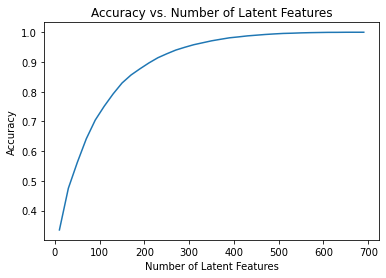

In [716]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [699]:
df_train = user_item_interaction.head(40000)
df_test = user_item_interaction.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test["user_id"].unique().tolist()
    test_arts = df_test["article_id"].unique().tolist()
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [883]:
print("the number of users thart are in the training and test set are {}".format(len(set(test_idx) & set(df_train["user_id"]))))

the number of users thart are in the training and test set are 20


In [884]:
print("we cannot make predictions on {} users because they are not on the training set".format(len(set(test_idx) - set(df_train["user_id"]))))

we cannot make predictions on 662 users because they are not on the training set


In [885]:
print("we can make predictions on {} articles because they are in both training and test set".format(len(set(test_arts) & set(df_train["article_id"]))))

we can make predictions on 574 articles because they are in both training and test set


In [889]:
print("we can make predictions on all articles because there are {} artiles that are in both training and test set".format(len(set(test_arts) - set(df_train["article_id"]))))

we can make predictions on all articles because there are 0 artiles that are in both training and test set


In [890]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d 
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [701]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [702]:
print("U shape {}".format(u_train.shape))
print("S shape {}".format(s_train.shape))
print("VT shape {}".format(vt_train.shape))

U shape (4487, 4487)
S shape (714,)
VT shape (714, 714)


In [892]:
pd.Series(user_item_train.columns).isin(user_item_test.columns)

0       True
1       True
2       True
3      False
4       True
       ...  
709     True
710     True
711     True
712     True
713     True
Name: article_id, Length: 714, dtype: bool

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

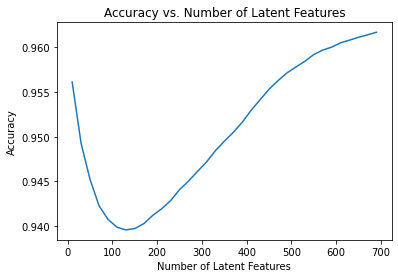

In [906]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
predictable_test_user_rows =  pd.Series(user_item_train.index).isin(user_item_test.index)
predictable_article_cols = pd.Series(user_item_train.columns).isin(user_item_test.columns)
predictable_test_user_item = user_item_test.loc[set(user_item_test.index) & set(user_item_train.index)]

def predict_user_item_interaction(n_features):
    "Returns user_item matrix with predicted interactions using n_features"
    # restructure with k latent features
    reshaped_u_train = u_train[predictable_test_user_rows, :n_features]
    reshaped_s_train = np.diag(s_train[:n_features])
    reshaped_vt_train = vt_train[:n_features, predictable_article_cols]
    
    # take dot product
    return np.dot(np.dot(reshaped_u_train, reshaped_s_train), reshaped_vt_train)
    
for n_features in num_latent_feats:
    pred_interactions = predict_user_item_interaction(n_features)
    
    # compute error for each prediction to actual value
    diffs = np.subtract(predictable_test_user_item, pred_interactions)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/len(predictable_test_user_item.values.flatten()))
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

In [881]:
pred_interactions = predict_user_item_interaction(700)
pred_interactions.round()
print("Proportion of positives in the test matrix {:.0%}".format(predictable_test_user_item.values.flatten().sum()/ len(predictable_test_user_item.values.flatten())))
print("Accuracy: {:.2%}".format(accuracy_score(pred_interactions.flatten().astype(int), predictable_test_user_item.values.flatten())))
print(pd.DataFrame(confusion_matrix(pred_interactions.flatten().astype(int), predictable_test_user_item.values.flatten()), columns=["pred 0", "pred 1"], index=["true 0", "true 1"]).to_markdown())

Proportion of positives in the test matrix 2%
Accuracy: 97.23%
|        |   pred 0 |   pred 1 |
|:-------|---------:|---------:|
| true 0 |    11157 |      213 |
| true 1 |      105 |        5 |


At first glance it seems that we are doing great in terms of accuracy, but after having a closer look at the test data we can clearly see that the high accuracy is due to having a highly imbalanced dataset with only 2% of 1s, we can confirm this by looking at a confusion matrix where most of the actual true interactions are not predicted, but to answer the question the more features the more actual interactions we predict.

**how would I determine if the recommendations of a new system I might implement does a better job than the current method?**

The best way in my opinion would be to do a online A/B testing where the experimental group would be fed with the recommendations given by the proposed system and the control group would have recommendations fed by the current system, some metrics we might use:
* The average position of articles clicked on the recomendation list, this woudl tell us if we are doing better recommendations
* Average time spent on the platform since more time spent on the platform would indicate that the user is interested in the recommended content

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])